In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance
import math

In [2]:
path_1 = "COMP9517 20T2 Group Project Image Sequences/Fluo-N2DL-HeLa/Sequence 1/t000.tif"
image_1 = cv2.imread(path_1)
img = image_1.copy()

In [3]:
def ConstrastStretching(I):
    #get the minimal pixel value
    c = np.amin(I)
    #get the maxmial pixel value
    d = np.amax(I)
    a = 0
    b = 255
    #given funcition
    O = (I-c)*((b-a)/(d-c))+a
    #transform the datatype into uint8
    O = O.astype('uint8')
    return O

def normalize(image):
    img = image.copy().astype(np.float32)
    img -= np.mean(img)
    img /= np.linalg.norm(img)
    img = np.clip(img, 0, 255)
    img *= (1./float(img.max()))
    return (img*255).astype(np.uint8)

def Sobel_gradient(blurred):

    gradX = cv2.Sobel(blurred, ddepth=cv2.CV_32F, dx=1, dy=0)
    gradY = cv2.Sobel(blurred, ddepth=cv2.CV_32F, dx=0, dy=1)
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    return gradX, gradY, gradient

uint8


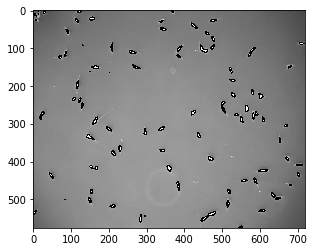

In [8]:
import ImageLoader


class ObjectTracker():
    def __init__(self):
        pass

    def ContrastStretch(self, img):
        max_inten = np.max(img)
        min_inten = np.min(img)
        img = (img - min_inten) * (255 / (max_inten - min_inten))
        return img.astype(np.uint8)

    def GaussianBlur(img, window = 5):
        return cv2.GaussianBlur(img, (window, window), 0)

    def img_subtrac(imga, imgb):
        return imga.astype(np.int32) - imgb

    def img_scale(img, scal):
        img = img * scal
        return img.astype(np.int32)

    def img_add(imga, imgb):
        return imga + imgb

    def find_contours(self, img, dst):
        contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cords = []
        for contour in contours:
            (x, y, w, h) = cv2.boundingRect(contour)
            if cv2.contourArea(contour) < 60:
                continue
            cv2.rectangle(dst, (x,y), (x+w, y+h), (0,255,0), 2)
            cords.append((x, y, w, h))
            #cv2.drawContours(dst, contour, -1, (0, 255, 0), 2)
        return cords


if __name__ == '__main__':
    path = "COMP9517 20T2 Group Project Image Sequences/PhC-C2DL-PSC/Sequence 1/t001.tif"
    path2 = "COMP9517 20T2 Group Project Image Sequences/Fluo-N2DL-HeLa/Sequence 1/t001.tif"
    img = ImageLoader.ImageLoader.load_img(path)
    img2 = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = ConstrastStretching(img)
    gblur = ObjectTracker.GaussianBlur(img)
    ret, thresh = cv2.threshold(gblur,200,255,cv2.THRESH_BINARY)
    _, contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    centers = []
    radiuses = {}
    contour_dic = {}
    for contour in contours:
        (x,y), radius = cv2.minEnclosingCircle(contour)
        center = (x, y)
        centers.append(center)
        radiuses[center] = radius
        contour_dic[center] = contour
        cv2.drawContours(img2, [contour],-1, (0, 0, 0), 2)
        #print(center)
    #cv2.drawContours(img, contours, -1, (0,255,0),3)
    #plt.imshow(thresh)
    #kernel = np.ones((5,5),np.uint8)
    #eroded = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    plt.imshow(img2)

In [7]:
def mitosis_detection_2(img, thresh, contours, standard_distance):
    centers = []
    radiuses = {}
    contour_dic = {}
    for contour in contours:
        (x,y), radius = cv2.minEnclosingCircle(contour)
        center = (x, y)
        centers.append(center)
        radiuses[center] = radius
        contour_dic[center] = contour
    kernel = np.ones((3,3),np.uint8)
    tmp = cv2.erode(thresh, kernel, iterations = 5)
    _, tmp_contours, _ = cv2.findContours(tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    tmp_centers = []
    for contour in tmp_contours:
        (x,y), radius = cv2.minEnclosingCircle(contour)
        center = (x, y)
        tmp_centers.append(center)
    dividing_cells = set()
    E_distances = distance.cdist(tmp_centers, tmp_centers, metric='euclidean')
    for x in range(len(E_distances)):
        for y in range(len(E_distances)):
            if E_distances[x][y] < standard_distance and x != y:
                point_1 = tmp_centers[x]
                point_2 = tmp_centers[y]
                dividing_cells.add(point_1)
                dividing_cells.add(point_2)
    for center in dividing_cells:
        for x in centers:
            dist = math.sqrt((x[0]-center[0])**2 + (x[1]-center[1])**2)
            if dist < radiuses[x]:
                contour = contour_dic[x]
                cv2.drawContours(img, [contour],-1, (0,0,0), 5)
    return img

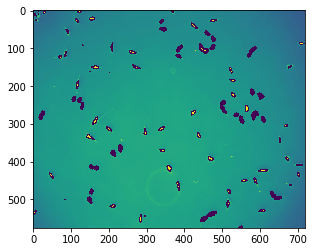

In [8]:
kernel = np.ones((3,3),np.uint8)
img = mitosis_detection_2(img, thresh, contours, 25)
plt.imshow(img)

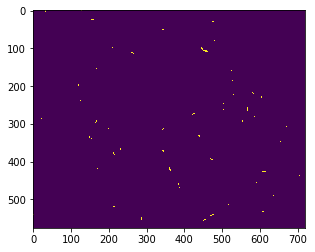

In [6]:
kernel = np.ones((2,2),np.uint8)
tmp = cv2.erode(thresh, kernel, iterations = 3)
plt.imshow(tmp)

In [5]:
def mitosis_detection_3(img, thresh, contours, standard_distance):
    centers = []
    radiuses = {}
    contour_dic = {}
    for contour in contours:
        (x,y), radius = cv2.minEnclosingCircle(contour)
        center = (x, y)
        centers.append(center)
        radiuses[center] = radius
        contour_dic[center] = contour
    kernel = np.ones((2,2),np.uint8)
    tmp = cv2.erode(thresh, kernel, iterations = 3)
    _, tmp_contours, _ = cv2.findContours(tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    tmp_centers = []
    for contour in tmp_contours:
        (x,y), radius = cv2.minEnclosingCircle(contour)
        center = (x, y)
        tmp_centers.append(center)
    dividing_cells = set()
    E_distances = distance.cdist(tmp_centers, tmp_centers, metric='euclidean')
    for x in range(len(E_distances)):
        for y in range(len(E_distances)):
            if E_distances[x][y] < standard_distance and x != y:
                point_1 = tmp_centers[x]
                point_2 = tmp_centers[y]
                dividing_cells.add(point_1)
                dividing_cells.add(point_2)
    for center in dividing_cells:
        for x in centers:
            dist = math.sqrt((x[0]-center[0])**2 + (x[1]-center[1])**2)
            if dist < radiuses[x]:
                contour = contour_dic[x]
                cv2.drawContours(img, [contour],-1, (125,0,0), 2)
    return img

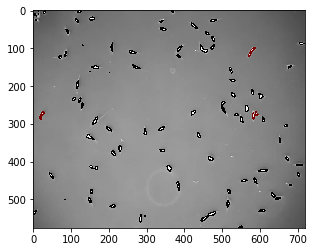

In [7]:
img2 = mitosis_detection_3(img2, thresh, contours, 13)
plt.imshow(img2)

In [9]:
_, tmp_contours, _ = cv2.findContours(tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
tmp_centers = []
for contour in tmp_contours:
    (x,y), radius = cv2.minEnclosingCircle(contour)
    center = (x, y)
    tmp_centers.append(center)
dividing_cells = set()
E_distances = distance.cdist(tmp_centers, tmp_centers, metric='euclidean')
for x in range(len(E_distances)):
    for y in range(len(E_distances)):
        if E_distances[x][y] < 25 and x != y:
            point_1 = tmp_centers[x]
            point_2 = tmp_centers[y]
            dividing_cells.add(point_1)
            dividing_cells.add(point_2)
print(dividing_cells)
for center in dividing_cells:
    for x in centers:
        dist = math.sqrt((x[0]-center[0])**2 + (x[1]-center[1])**2)
        if dist < radiuses[x]:
            contour = tmp_dic[x]
            cv2.drawContours(img, [contour],-1, (0,0,0), 5)
plt.imshow(img)

{(1048.5, 379.5), (678.727294921875, 33.6363639831543), (1060.3182373046875, 395.8636474609375), (692.1829223632812, 15.40243911743164)}


NameError: name 'centers' is not defined